In [ ]:
%cd /content
!git clone --depth 1 https://github.com/tensorflow/models
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content
Cloning into 'models'...
remote: Enumerating objects: 2198, done.
remote: Counting objects: 100% (2198/2198), done.
remote: Compressing objects: 100% (1900/1900), done.
remote: Total 2198 (delta 527), reused 958 (delta 272), pack-reused 0
Receiving objects: 100% (2198/2198), 30.43 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (527/527), done.
/content/models/research
Processing /content/models/research
     |████████████████████████████████| 8.6MB 6.4MB/s 
     |████████████████████████████████| 358kB 53.2MB/s 
     |████████████████████████████████| 849kB 56.4MB/s 
     |████████████████████████████████| 71kB 250kB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 63.8MB 47kB/s 
     |████████████████████████████████| 1.4MB 52.3MB/s 
     |████████████████████████████████| 153kB 61.4MB/s 
     |██████████████████████████

## Imports and Setup

In [32]:
import matplotlib
import matplotlib.pyplot as plt

import os
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Utilities

In [33]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [34]:
LABEL_FILENAME = 'labelmap.pbtxt'
PATH_TO_LABELS = "/content/drive/My Drive/Colab Notebooks/tensorflow_obj_det/workspace/zoo_detector/data/annotations/labelmap.pbtxt"

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [35]:
#PATH_TO_CFG = os.path.join('/Users/manasc12/PycharmProjects/tensorflow/models/research/object_detection/configs/tf2',model_name + '.config')
PATH_TO_CFG = os.path.join('/content/drive/My Drive/Colab Notebooks/tensorflow_obj_det/workspace/zoo_detector/trained_models/efficientdet-d0/pipeline_file.config')

PATH_TO_CKPT = os.path.join('/content/drive/My Drive/Colab Notebooks/tensorflow_obj_det/workspace/zoo_detector/trained_models/efficientdet-d0')

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint #You might think it's Optional but believe me its needed
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-7')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [36]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [37]:
category_index

{1: {'id': 1, 'name': 'Tiger'},
 2: {'id': 2, 'name': 'Lion'},
 3: {'id': 3, 'name': 'Bear'}}

Saving Tiger.jpg to Tiger.jpg


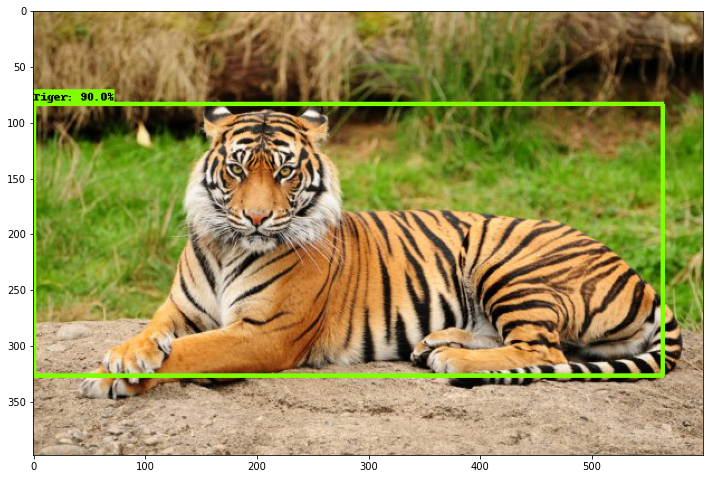

In [38]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i=1
for fn in uploaded.keys():
  image_path = '/content/models/research/' + fn
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in detections:
    keypoints = detections['detection_keypoints'][0].numpy()
    keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints,
        keypoint_scores=keypoint_scores,
        keypoint_edges=get_keypoint_tuples(configs['eval_config']))

  plt.figure(figsize=(12,16))
  plt.imshow(image_np_with_detections)
  plt.show()
  i=i+1
